In [ ]:
#hide 

%load_ext autoreload
%autoreload 2

In [ ]:
#default_exp train

# Train
> Training and evaluation of the model using FastAI utilities

In [ ]:
#exporti

from transformers import DistilBertTokenizer
from fastai.data.core import DataLoaders
from fastai.vision.all import *
from DSAI_proj.dataset import *
from DSAI_proj.model import *
from fastai.vision import *
from torch import nn
from pandas import DataFrame
import torch

First, let's create our loss function. This will tell our model how wrong it is by calculating how far the predictions are from the output. Here, we will use cross entropy loss as our criterion. We can do this by viewing each token as a separate class, and hence provide a one-for-one comparison of tokens at each position.

In [ ]:
#export

class TagLineLoss(nn.Module):
    
    def __init__(self):
        super(TagLineLoss, self).__init__()
        self.criterion = torch.nn.CrossEntropyLoss()
    
    def forward(self, output, target):
        return self.criterion(input=output, target=target)

We also define a splitter which will group the parameters of the different models to allow for unfreezing of the layers subsequently. 

In [ ]:
#export

def splitter_func(model: nn.Module):
    return [params(model.cnn_encoder),
            params(model.text_encoder),
            params(model.meta_encoder),
            params(model.decoder)]

In [ ]:
#hide

# dataset creation
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
poster_img_dir = "poster_img/"
backdrop_img_dir = "backdrop_img/"
input_max_length, labels_max_length = 80, 10
height = width = 128
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
bs = 32

tfms = Compose([Tokenize(tokenizer=tokenizer, input_max_length=input_max_length, labels_max_length=labels_max_length),
                         RandomResizeCrop(width=width, height=height, method=Image.BILINEAR),
                         ToTensor(),
                         NormalizeStandardize(mean=mean, std=std)])

train_ds = MovieDataset(poster_img_dir=poster_img_dir,
                        backdrop_img_dir=backdrop_img_dir,
                        ds_type="train",
                        transforms=tfms)

valid_ds = MovieDataset(poster_img_dir=poster_img_dir,
                        backdrop_img_dir=backdrop_img_dir,
                        ds_type="valid",
                        transforms=tfms)

dls = DataLoaders.from_dsets(train_ds, valid_ds, batch_size=bs)
sample = dls.one_batch()
model = TaglinePredictorModel(vocab_size=30522, meta_features=sample[0][3].shape[-1])

train dataset created!
valid dataset created!
Model is created!


Finally, we can begin the training. To do this, we leverage the FastAI library as a training vehicle as it provides many advanced training techniques at our fingertips with simple APIs. 

In [ ]:
learn = Learner(dls, model, loss_func=TagLineLoss(), opt_func=Adam, splitter=splitter_func, cbs=CudaCallback, wd=1e-3).to_fp16()

We run a function called lr_find first which plots different learning rates against loss. We use this to determine an optimal learning rate for our task. We pick the learning rate corresponding to the middle point of the steepest part of the downward sloping curve, which in this case is about 1e-2.

SuggestedLRs(lr_min=0.10964782238006592, lr_steep=0.9120108485221863)

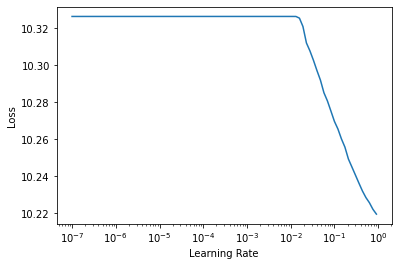

In [ ]:
learn.lr_find()

We then run a fit on the model for 2 epochs first to verify it's progress. 

In [ ]:
learn.fit_one_cycle(3, 1e-1)

epoch,train_loss,valid_loss,time
0,10.092417,10.073622,00:40
1,10.074081,10.073622,00:41
2,10.073076,10.073622,00:40


This is followed by a unfreezing of all layers and running of lr_find again to find the optimal lr range for this next phase of training. We notice that the graph now is relatively flat before suddenly spiking upwards. We will pick a learning rate way before the training diverges, in this case about 1e-5. 

We use something called differential learning rates to train different parts of the model at different learning rates. This is done at the next stage using the slice. The upper bound will be set at a factor of 10 less than the initial learning rate as good practice, so we will use 1e-3 in this case. This time, we train for 3 epochs instead as well.

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=4.365158383734524e-05)

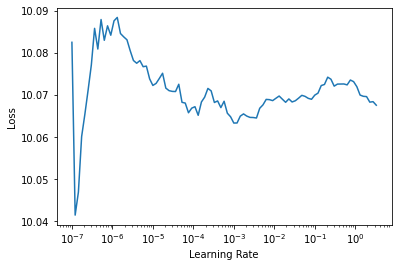

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,time
0,10.068838,10.073622,00:49
1,10.070781,10.073622,00:50
2,10.069448,10.073622,00:50
3,10.069201,10.073622,00:49
4,10.070787,10.073622,00:50


As we can see, even with extreme measures taken to avoid overfitting such as unfreezing batch/layer norm during fine-tuning, reducing batch size, adding weight decay, and cranking up the learning rate, the model still overfits at practically the first epoch. This probably means that the model architecture itself can be further improved, as well as the augmentation techniques. We shall explore these further in the next section on analysis. 

For now, we shall save the model to experiment on the test set.

In [ ]:
model = learn.model
save_path = 'saved_model.pt'
torch.save(model.state_dict(), save_path)

We shall also write the necessary functions for loading the saved model and generating the predictions.

In [ ]:
#exporti

def load_model(model_path: str, **kwargs):
    model = TaglinePredictorModel(**kwargs)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to("cpu")
    return model

In [ ]:
#export

def predict_one_batch(tokenizer,
                      dls,
                      mode: str,
                      model_path: str) -> DataFrame:

    if mode != "train":
        x, y = dls.valid.one_batch()
    else:
        x, y = dls.train.one_batch()
    model = load_model(model_path=model_path, vocab_size=30522, meta_features=x[3].shape[-1])
    x = model(x)
    preds = torch.argmax(x, dim=1)
    results = {"preds" : [tokenizer.decode(p) for p in preds], "labels" : [tokenizer.decode(t) for t in y]}
    return pd.DataFrame.from_dict(results)

In [ ]:
results_df = predict_one_batch(tokenizer=tokenizer, dls=dls, mode="train", model_path=save_path)
results_df.head()

Model is created!


,preds,labels
0,[CLS] the's... [PAD] [PAD] [SEP],[CLS] rule school save world [SEP] [PAD] [PAD] [PAD] [PAD]
1,[CLS] the is s... [PAD] [PAD] [SEP],[CLS] every generation legend every journey first step every [SEP]
2,[CLS] the's. the.. [PAD] [SEP],[CLS] bad cops good cops's bullitt [SEP]
3,[CLS] the's.... [PAD] [SEP],[CLS] story won't go away [SEP] [PAD]
4,[CLS] the the s.... [PAD] [SEP],[CLS] one pillow bed... one desire [SEP]
